In [1]:
!pip install gdown

import gdown
import shutil

# Destination directory where the user will download the data https://drive.google.com/file/d/1Lkijp_uhdROHhc6MBQrRDF2Xmee8OIEB/view?usp=sharing
destination_path = '/content'

# Direct download link for the ZIP file
folder_id ='1Lkijp_uhdROHhc6MBQrRDF2Xmee8OIEB'
zip_file_url = f'https://drive.google.com/uc?id={folder_id}'


# Download the ZIP file
zip_file_path = destination_path + '/DATA.zip'
gdown.download(zip_file_url, zip_file_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1Lkijp_uhdROHhc6MBQrRDF2Xmee8OIEB
To: /content/DATA.zip
100%|██████████| 200M/200M [00:04<00:00, 44.9MB/s]


'/content/DATA.zip'

In [2]:
# Extract the downloaded ZIP file
shutil.unpack_archive(zip_file_path, destination_path)

print("Data has been downloaded and extracted to:", destination_path)

Data has been downloaded and extracted to: /content


In [3]:
import os

# Replace 'folder1_path' and 'folder2_path' with the actual paths of your two folders
folder1_path = '/content/Not_Resume'
folder2_path = '/content/Resume'

# Create a new folder named 'DATA'
data_folder_path = '/content/DATA'
os.makedirs(data_folder_path, exist_ok=True)

# Move the existing folders into the 'DATA' folder
shutil.move(folder1_path, data_folder_path)
shutil.move(folder2_path, data_folder_path)


'/content/DATA/Resume'

# Data Processing

In [1]:
import numpy as np

#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code.
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import tensorflow as tf


In [2]:
#Iterate through all images in Parasitized folder, resize to 64 x 64
#Then save as numpy array with name 'dataset'
#Set the label to this as 0


image_directory = '/content/DATA/'
SIZE = 640
dataset = []
label = []

# Load images from 'Resume' folder
Resume_images = os.listdir(image_directory + 'Resume/')
for i, image_name in enumerate(Resume_images):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg','.PNG','JPG','JPEG')):
        image_path = os.path.join(image_directory, 'Resume', image_name)
        image = cv2.imread(image_path)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

# Load images from 'Not_Resume' folder
Not_Resume_images = os.listdir(image_directory + 'Not_Resume/')
for i, image_name in enumerate(Not_Resume_images):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg','.PNG','JPG','JPEG')):
        image_path = os.path.join(image_directory, 'Not_Resume', image_name)
        image = cv2.imread(image_path)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)



In [6]:
print(len(label))

605


In [7]:
print(len(dataset))

605


# Model

In [8]:
#Apply CNN
# ### Build the model

#############################################################
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 640, 640, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 320, 320, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 320, 320, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 320, 320, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 32)      9248  

In [3]:
### Split the dataset
#
# I split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Convert lists to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(label), test_size = 0.20, random_state = 0)
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# ### Training the model
# As the training data is now ready, I will use it to train the model.

#Fit the model
history = model.fit(np.array(X_train),
                         y_train,
                         batch_size =4,
                         verbose = 1,
                         epochs = 100,
                         validation_split = 0.1,
                         shuffle = False
                      #   callbacks=callbacks
                     )

Epoch 1/100
109/109 [==============================] - 30s 191ms/step - loss: 0.8464 - accuracy: 0.6506 - val_loss: 12.1548 - val_accuracy: 0.5306
Epoch 2/100
109/109 [==============================] - 19s 178ms/step - loss: 0.5113 - accuracy: 0.7816 - val_loss: 2.8735 - val_accuracy: 0.5714
Epoch 3/100
109/109 [==============================] - 19s 177ms/step - loss: 0.4142 - accuracy: 0.8161 - val_loss: 0.6083 - val_accuracy: 0.7551
Epoch 4/100
109/109 [==============================] - 19s 178ms/step - loss: 0.5056 - accuracy: 0.7747 - val_loss: 0.2991 - val_accuracy: 0.8571
Epoch 5/100
109/109 [==============================] - 19s 179ms/step - loss: 0.3668 - accuracy: 0.8391 - val_loss: 0.3687 - val_accuracy: 0.8163
Epoch 6/100
109/109 [==============================] - 20s 179ms/step - loss: 0.3039 - accuracy: 0.8782 - val_loss: 0.4178 - val_accuracy: 0.8163
Epoch 7/100
109/109 [==============================] - 19s 178ms/step - loss: 0.2646 - accuracy: 0.8851 - val_loss: 0.2299 

31/31 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        57
           1       0.85      0.94      0.89        64

    accuracy                           0.88       121
   macro avg       0.88      0.87      0.87       121
weighted avg       0.88      0.88      0.88       121



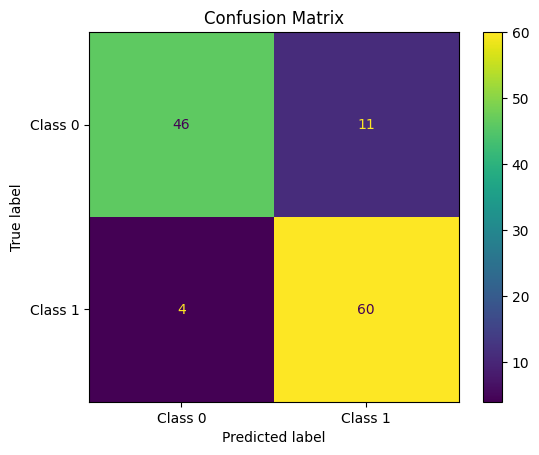

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming X_test is your input data
X_test_reshaped = np.array(X_test)
batch_size = 4

# Get predictions
y_pred = model.predict(X_test_reshaped, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes))




# Plot confusion matrix with sklearn's ConfusionMatrixDisplay for colored matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()


4/4 [==============================] - 5s 659ms/step - loss: 0.2909 - accuracy: 0.8760
Test_Accuracy: 87.60%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


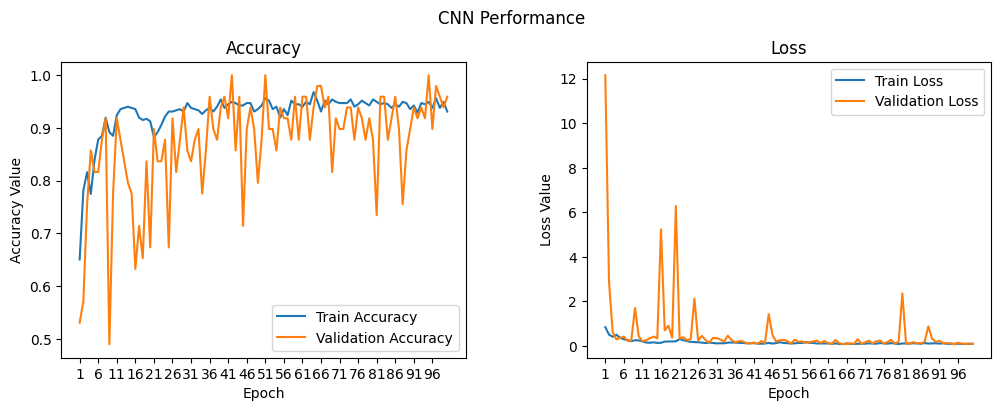

In [12]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))




f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


#Save the model
model.save('malaria_cnn.h5')


In [4]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers import Conv2D, Input, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info
from keras.layers import add

NETWORK_W = 640
NETWORK_H = 640

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'


from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    skip_connection = None

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1:
            x = ZeroPadding2D(((1, 0), (1, 0)), name='zerop_' + str(conv['layer_idx']))(x)

        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)

        if conv['bnorm']:
            x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)

        if conv['activ'] == 1:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2:
            x = Activation('relu', name='relu_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x], name='add_' + str(conv['layer_idx'] + 1)) if skip else x

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,Dense,Flatten
from tensorflow.keras.optimizers import Adam


input_image = Input(shape=(640, 640, 3), name='input_0')

# Layer 0
x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
layer_0 = x

# Layer 1
x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
layer_1 = x

# Layer 2
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
layer_2 = x

# route 1 (layers = -2)
x = layer_1

# Layer 3 => 5
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                    {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                    {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
               skip=True)

# Layer 8 => 8
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
layer_8 = x

# route 8+2 (layers = -1, -7)
x = concatenate([layer_8, layer_2], name='concat_9')

# Layer 10 => 11
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                    {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
layer_11 = x

# Layer 12
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
layer_12 = x

# route 11 (layers = -2)
x = layer_11

# Layer 14 => 16
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                    {'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                    {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
               skip=True)

# Layer 18 => 19
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                    {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
               skip=True)

# Layer 21
x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}])
layer_21 = x

# route 21+12 (layers = -1,-10)
x = concatenate([layer_21, layer_12], name='concat_22')

# Layer 23 => 24
x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                    {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
layer_24 = x

# Layer 25
x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
layer_25 = x

# route 52+25 (layers = -1,-28)
x = layer_25

# Add two convolutional layers and a dropout layer
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Dropout(0.5)(x)

# Flatten the matrix
x = Flatten()(x)

# Reduce its size (you can adjust the number of units in Dense layer)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.25)(x)

# Final layer with 1 neuron and sigmoid activation
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[input_image], outputs=[output])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 convn_0 (Conv2D)            (None, 640, 640, 32)         896       ['input_0[0][0]']             
                                                                                                  
 BN_0 (BatchNormalization)   (None, 640, 640, 32)         128       ['convn_0[0][0]']             
                                                                                                  
 relu_0 (Activation)         (None, 640, 640, 32)         0         ['BN_0[0][0]']                
                                                                                            

In [13]:
# Compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Specify the path to your data
data_path = '/content/DATA'

# Create an ImageDataGenerator with rescaling and other augmentations if needed
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create separate generators for training, validation, and test
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(640, 640),
    batch_size=4,
    class_mode='binary',
    subset='training'  # Use subset parameter for the training set
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(640, 640),
    batch_size=4,
    class_mode='binary',
    subset='validation'  # Use subset parameter for the validation set
)

test_generator = datagen.flow_from_directory(
    data_path,
    target_size=(640, 640),
    batch_size=4,
    class_mode='binary',
    subset='validation'  # Use subset parameter for the test set
)

# Fit the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Found 485 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/100
121/121 [==============================] - 68s 405ms/step - loss: 1.3517 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 2/100
121/121 [==============================] - 45s 369ms/step - loss: 0.6932 - accuracy: 0.5156 - val_loss: 0.6930 - val_accuracy: 0.5167
Epoch 3/100
121/121 [==============================] - 44s 362ms/step - loss: 0.6931 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.5167
Epoch 4/100
121/121 [==============================] - 44s 362ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6929 - val_accuracy: 0.5167
Epoch 5/100
 31/121 [======>.......................] - ETA: 30s - loss: 0.6935 - accuracy: 0.4758

In [ ]:

# Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=0)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Predict the classes for the test data
    y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = test_generator.classes

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print classification report
    report = classification_report(y_test_classes, y_pred_classes, target_names=['0', '1'])
    print(report)